# Использование BERT для задачи классификации последовательности




[Исходный туториал](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) + материалы курса Кати Артемовой  на ФКН

**Важные ссылки про BERT**

[Devlin et al 2019](https://arxiv.org/pdf/1810.04805.pdf) - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding - статья, презентующая BERT

[Vaswani et al 2017](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) - Attention is all you need - статья, презентующая трансформеры

[Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) by Jay Allamar - архитектура трансформера в картингах и гифках

[Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) by harvardnlp -код трансформера на торче, реализующий статью по абзацам

[Transformers](https://huggingface.co/transformers/) by hugging face -  главная open source библиотека, откуда можно брать предобученные бертоподобные модели


Сегодня посмотрим, как можно использовать BERT (или любую другую подобную модель) с помощью библиотеки Transformers.

Общий пайплайн:
BERT используется как начальный блок модели и считает контекстные вектора для слов.
Поверх этого блока мы добавляем "голову" модели, ее архитектура зависит от задачи.
Веса BERT предобучены, но мы проводим дообучение (fine-tuning) на целевой задаче.




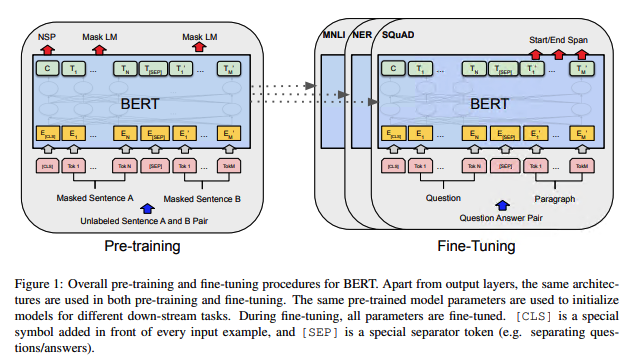

Наша сегодняшняя задача - классификация отзывов.
Данные - отзывы на приложения в Google Play, классы:  negative (1,2), neutral (3), positive (4,5) 

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face 

In [ ]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 50.0 MB/s 
     |████████████████████████████████| 6.5 MB 42.2 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 64.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.16.2



Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 163MB/s]


In [ ]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [ ]:
df = pd.read_csv("reviews.csv")

In [ ]:
df.shape

(15746, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [ ]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


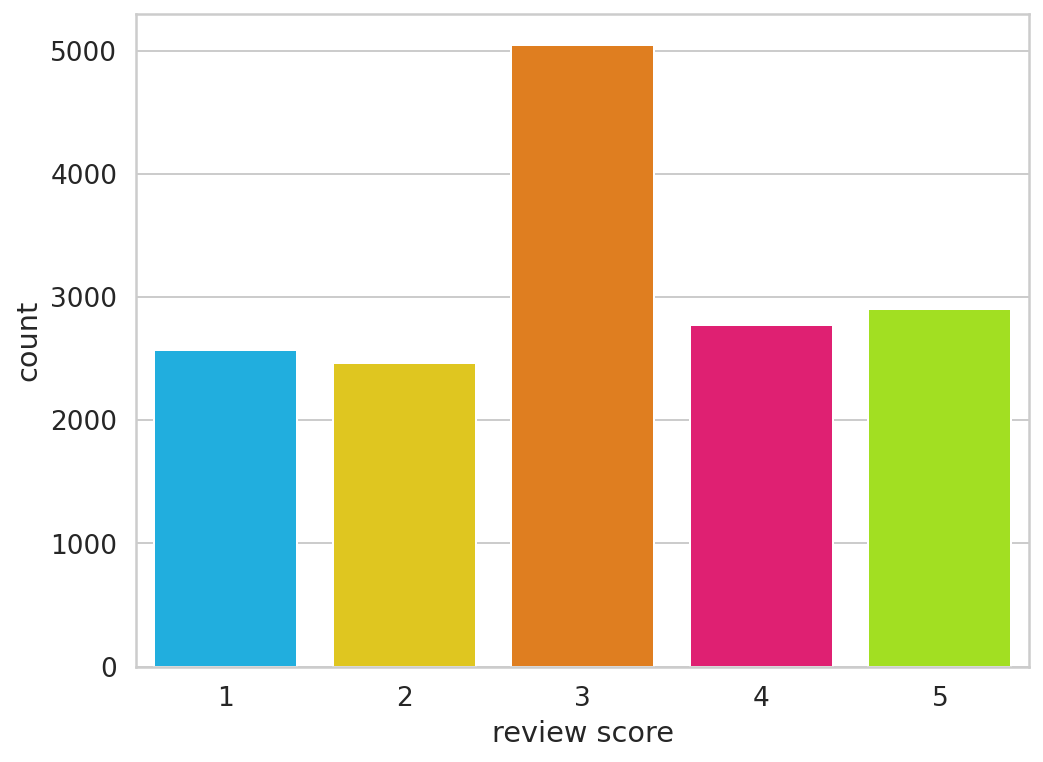

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы. 
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


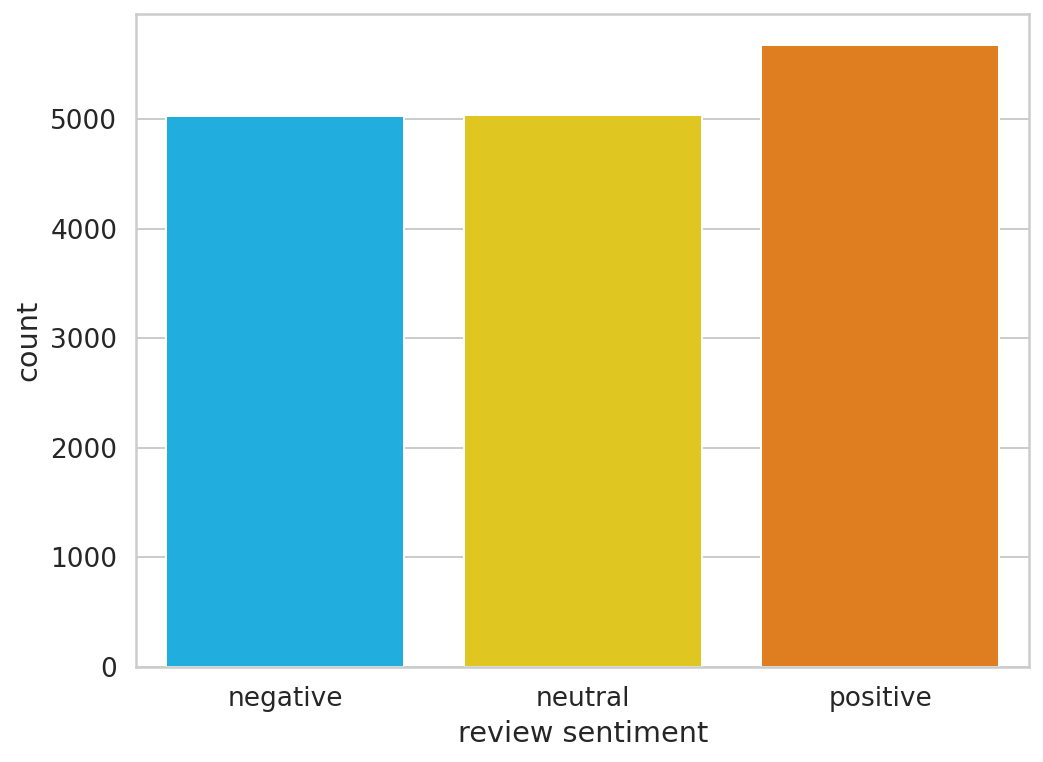

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.



Бертоподобных моделей огромное множество, но если они интегрированы в библиотеку Transformers, сменить одну модель на другую очень просто. Вот [здесь](https://huggingface.co/transformers/pretrained_models.html) можно посмотреть, какие модели есть библиотеке. 

Model id в таблице используются для двух вещей - подгрузки весов в саму модель и подгрузки правильного токенизатора. Вам не нужно самим добавлять спецсимволы и строить индексы словаря, это сделает токенайзер, соотвествующий выбранной модели.
Сегодняшний выбор - модель 'bert-base-cased'

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Посмотрим, как работает модель токенизации для BERT.



In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: He started a new book, it was quite readable
   Tokens: ['He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Token IDs: [1124, 1408, 170, 1207, 1520, 117, 1122, 1108, 2385, 2373, 1895]


##  Специальные токены

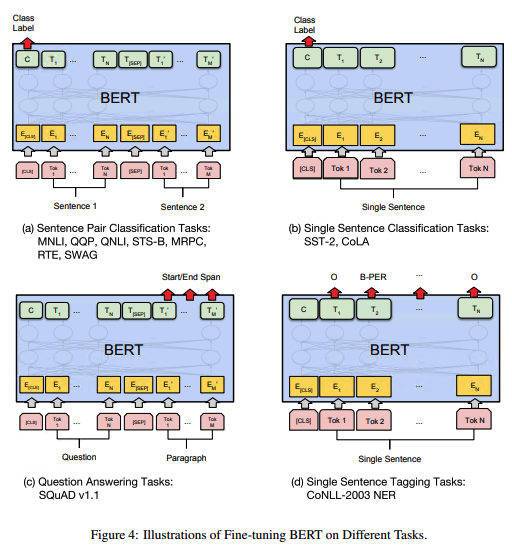



`[SEP]` - метка конца предложения


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Вся эта предобработка может быть сделана с помощью метода encode_plus

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Такая же длина будет и у *attention mask*

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Установим максимальную длину последовательности равной 160

In [ ]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [ ]:

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки 

In [ ]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))


Создадим итераторы по данным
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['review_text'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

["I had a problem with upgrading to Premium. They were quick with their response and fixed the problem right away. It's a good app for those familiar with the Franklin Covey system, and syncs well across devices.", 'Same issue as Don Smith who wrote a review on 10/10/19. Will consider this app but the lack of slide visuals and character visuals makes the app in-op. Current phone is the Google pixel 4xl......perhaps I misspoke in regards to the reply. My issue is not with the visuals but the lack of visuals. Everything is blank for me so literally can not see half of the content.', "I actually really love this app. I used it to create some serious personal progress. I purchased the full app but when I bought a new phone, it wouldn't let me sign out of my old device and into my new device. I emailed support about it...crickets. Never heard from them. If they can put together a decent support team I would give the app a 5 for sure.", 'But of a downgrade from wunderlist. Please add a butto

In [ ]:
data['targets']

tensor([2, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 2, 2, 2, 2])

## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Попробуем использовать эту модель 

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
last_hidden_state, pooled_output, hidden_states = bert_model( 
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  return_dict=False)


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели. 

In [ ]:
print(last_hidden_state.shape)
print(pooled_output.shape)
print(len(hidden_states))

torch.Size([1, 32, 768])
torch.Size([1, 768])
13


In [ ]:
for state in hidden_states:
  print(state.shape)

torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])


Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [ ]:
text1 = df.loc[16]['content']
text2 = df.loc[338]['content']
print(text1)
print(text2)

Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service.
Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for


In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer2 = PreTrainedTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
tokenizer2.sep_token = tokenizer.sep_token
tokenizer2.pad_token = tokenizer.pad_token

In [ ]:
encoding = tokenizer.encode_plus(
  text1,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

In [ ]:
encoding2 = tokenizer2.encode_plus(
  text1,
  max_length=50,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True,
  return_offsets_mapping=True
)

In [ ]:
print(encoding.keys())
print(encoding2.keys())

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])


In [ ]:
encoding2['offset_mapping']

tensor([[[  0,   0],
         [  0,   6],
         [  6,   7],
         [  7,   8],
         [  9,  13],
         [ 14,  17],
         [ 18,  20],
         [ 21,  24],
         [ 25,  31],
         [ 32,  41],
         [ 42,  50],
         [ 51,  58],
         [ 59,  64],
         [ 65,  73],
         [ 74,  76],
         [ 77,  80],
         [ 81,  88],
         [ 89, 101],
         [101, 102],
         [103, 106],
         [107, 111],
         [112, 118],
         [119, 123],
         [124, 127],
         [128, 130],
         [131, 133],
         [133, 134],
         [134, 135],
         [136, 138],
         [138, 139],
         [139, 140],
         [141, 145],
         [146, 150],
         [151, 152],
         [153, 161],
         [162, 165],
         [166, 169],
         [170, 171],
         [172, 178],
         [179, 186],
         [186, 187],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0

In [ ]:
encoding['input_ids']

tensor([[  101, 23320,   112,   189,  1256,  1383,  1146,  1141,  1423, 10993,
         15656,  1443,  1217,  2320,  1106,  2653,  7868, 16759,   119,  3949,
          1240, 24007,  1289,  1228,  1122,  1260,  1964,   119,  1135,   102]])

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict=False)

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'Get', 'your', 'greedy', 'hand', 'off', 'it', 'de', '##v', '.', 'It', '[SEP]']


In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')

17

In [ ]:
emb1 = last_hidden_state[0, 17]
emb1.shape

torch.Size([768])

In [ ]:
encoding2 = tokenizer.encode_plus(
  text2,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

last_hidden_state2, pooled_output2 = bert_model(
  input_ids=encoding2['input_ids'], 
  attention_mask=encoding2['attention_mask'],
  return_dict=False)

In [ ]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0])

['[CLS]',
 'Well',
 'designed',
 'and',
 'all',
 'however',
 'al',
 '##ot',
 'of',
 'the',
 'c',
 '##ru',
 '##tial',
 'features',
 'are',
 'locked',
 'behind',
 'the',
 'premium',
 'which',
 'u',
 'need',
 'to',
 'pay',
 'for',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index('premium')

18

In [ ]:
emb2 = last_hidden_state2[0, 1]
emb2.shape

torch.Size([768])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity( [emb1.detach().cpu().numpy()], [emb2.detach().cpu().numpy()])

array([[0.50464517]], dtype=float32)

Опишем наконец наш классификатор на основе BertModel

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

Перенесем на GPU один из наших батчей (для примера).

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Применим модель к данным.

In [ ]:
output = model(input_ids, attention_mask)
output

tensor([[ 0.5297, -0.3704,  0.3508],
        [ 0.7211, -0.9522, -0.3788],
        [ 0.3662, -0.2921, -0.1734],
        [ 0.3625, -0.5185,  0.4058],
        [ 0.7734,  0.0146, -0.7344],
        [ 0.5222, -0.5815, -0.4113],
        [ 0.5610, -0.1680, -0.3687],
        [-0.2049,  0.5436, -0.5340],
        [ 0.5701, -0.3247, -0.7452],
        [ 0.7474, -0.8923, -0.4439],
        [ 0.6459, -0.7971, -0.5833],
        [ 0.1213, -1.0518, -0.4651],
        [ 0.2027,  0.2440, -0.9495],
        [ 0.2665,  0.1556, -0.4168],
        [ 0.4015, -0.1666, -0.2669],
        [ 0.1709,  0.0257, -0.4017]], grad_fn=<AddmmBackward0>)

Если хотим получить вероятности классов, применяем SoftMax к выходу модели.

In [ ]:
F.softmax(output, dim=1)

tensor([[0.3961, 0.2909, 0.3130],
        [0.4446, 0.2422, 0.3132],
        [0.6045, 0.1625, 0.2330],
        [0.5477, 0.2357, 0.2167],
        [0.6289, 0.1761, 0.1950],
        [0.5411, 0.2177, 0.2412],
        [0.5020, 0.2836, 0.2144],
        [0.5496, 0.3105, 0.1398],
        [0.3299, 0.2894, 0.3806],
        [0.4371, 0.3016, 0.2613],
        [0.5042, 0.2752, 0.2205],
        [0.5012, 0.3035, 0.1953],
        [0.5399, 0.2124, 0.2477],
        [0.3931, 0.2966, 0.3103],
        [0.5776, 0.2105, 0.2120],
        [0.4582, 0.2764, 0.2654]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Обучение модели

Для дообучения модели будем использовать оптимизатор [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face. 



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [ ]:

#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False


In [ ]:
list(model.bert.encoder.layer[3].parameters())[0]

Parameter containing:
tensor([[ 0.0408,  0.0030,  0.0493,  ..., -0.0447,  0.0018,  0.0092],
        [-0.0179,  0.0101,  0.0018,  ..., -0.0078,  0.0205,  0.0202],
        [ 0.0064, -0.0355,  0.0388,  ...,  0.0118,  0.0331, -0.0531],
        ...,
        [ 0.1221, -0.0232,  0.1091,  ..., -0.0366, -0.0166,  0.0676],
        [-0.0261,  0.0560,  0.0429,  ...,  0.0124, -0.0057, -0.0347],
        [ 0.0665, -0.0589,  0.0258,  ...,  0.0240,  0.0202,  0.0290]],
       requires_grad=True)

In [ ]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели 

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.7657513116942571 accuracy 0.63898104429245
Val loss 0.6620123326778412 accuracy 0.7064802646636963

Epoch 2/2
----------
Train loss 0.6457155160858185 accuracy 0.711876392364502
Val loss 0.6364050817489624 accuracy 0.714104175567627

CPU times: user 18min 25s, sys: 4.96 s, total: 18min 30s
Wall time: 18min 46s



При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

In [ ]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

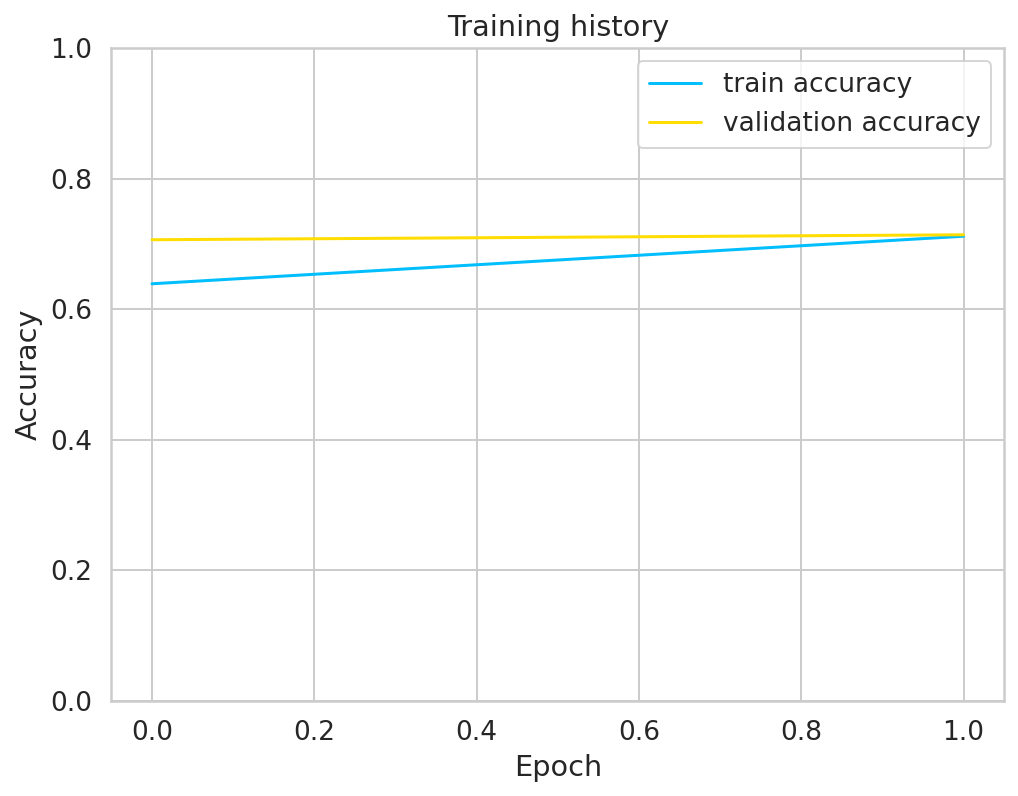

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
'''
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)
'''

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7068527936935425

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.69      0.72       262
     neutral       0.55      0.59      0.57       235
    positive       0.81      0.81      0.81       291

    accuracy                           0.71       788
   macro avg       0.70      0.70      0.70       788
weighted avg       0.71      0.71      0.71       788



Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы. 

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

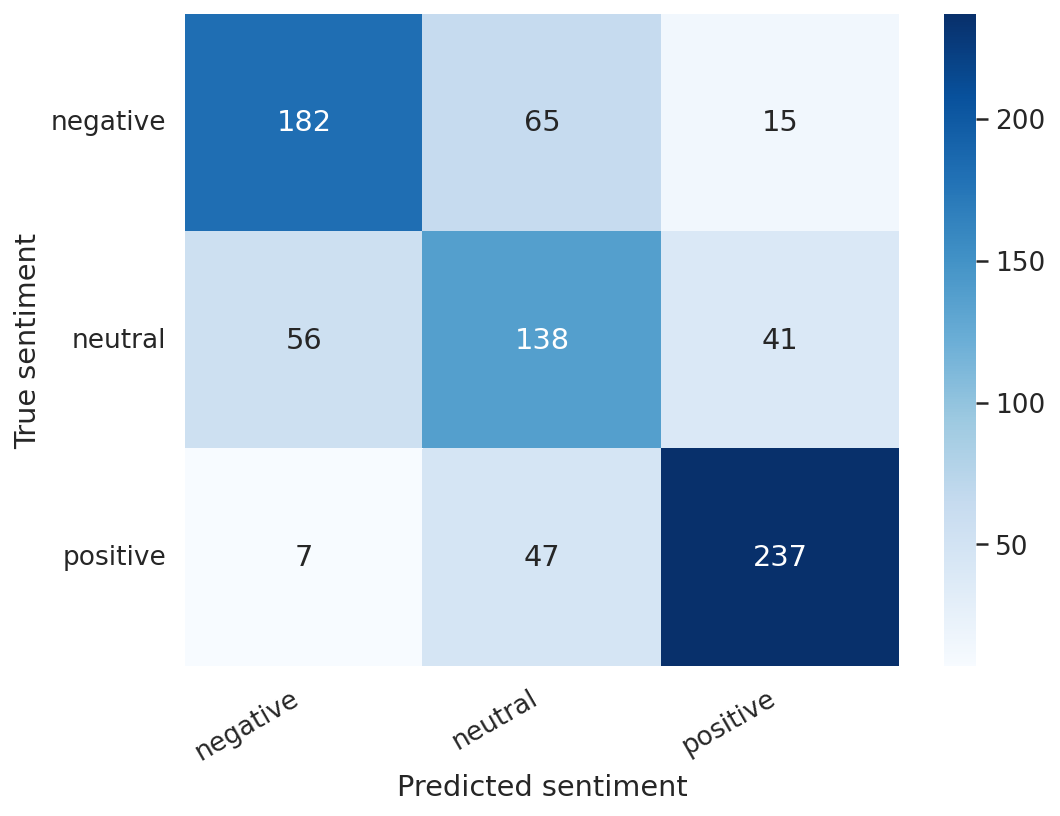

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы. 

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Good

True sentiment: negative


## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


##Trainer от HuggingFace

Библиотека HuggingFace предоставляет инструменты, которые упрощают обучение и оценку моделей, выложенных в репозиторий библиотеки. Рассмотрим эти инструменты на примере задачи анализа тональности. Будем обучать и оценивать модели на датасете imdb, состоящем из отзывов пользователей о фильмах. 

Оригинал: https://huggingface.co/transformers/custom_datasets.html#sequence-classification-with-imdb-reviews

Для загрузки датасета воспользуемся библиотекой datasets, реализованной HuggingFace. Данная библиотека предоставляет возможность быстро и удобно скачивать различные бенчмарки: https://huggingface.co/datasets

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
imdb_dataset["train"]["text"][:10]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [ ]:
imdb_dataset["train"]["label"][:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Сократим количество примеров, чтобы процесс обучения был быстрее.

In [ ]:
train_texts = imdb_dataset["train"]["text"][:2000]
train_labels = imdb_dataset["train"]["label"][:2000]
test_texts = imdb_dataset["test"]["text"][:1000]
test_labels = imdb_dataset["test"]["label"][:1000]

In [ ]:
del imdb_dataset

Выделим часть обучающих данных для оценки:

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

Токенизируем данные

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Создадим класс Dataset, который на каждой итерации будет возвращать токенизированный отзыв и класс:

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

Опишем функцию для подсчета метрик, которые хотим увидеть при оценке модели (по умолчанию будет вычисляться только loss):

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Зададим параметры обучения с помощью TrainingArguments:

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

Инициализируем модель и запустим fine-tune ее с помощью модуля Trainer. В данном модуле будет автоматически происходить итерация по эпохам, батчам, рассчет функции потерь и градиентов, ничего этого больше руками прописывать не нужно!

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1600
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 400


Step,Training Loss
10,0.596000
20,0.571900
30,0.514700
40,0.402600
50,0.245100
60,0.125700
70,0.051300
80,0.024300
90,0.014200
100,0.009200




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=400, training_loss=0.0647397192819335, metrics={'train_runtime': 294.1987, 'train_samples_per_second': 10.877, 'train_steps_per_second': 1.36, 'total_flos': 423895675699200.0, 'train_loss': 0.0647397192819335, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

Оценим модель на тестовых данных

In [ ]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")